In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import chardet
import re
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Concatenate, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.optimizers import Adam

In [31]:
df = pd.read_csv('data_output/charting_clean.csv', low_memory=False)

In [32]:
df_exploded = pd.read_csv('data_output/df_exploded_full.csv', low_memory=False)

In [33]:
df_exploded.head()

,Player,Sequence,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts
0,Novak Djokovic,6,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,1,0,0,0.0,0.0,0-0
1,Ben Shelton,f2n#,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,1,0,0,0.0,0.0,0-0
2,Novak Djokovic,4n,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,2,0,0,0.0,0.0,15-0
3,Novak Djokovic,6 f1 s1 f2,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,2,0,0,0.0,0.0,15-0
4,Ben Shelton,b19 b2 f3 j2*,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,2,0,0,0.0,0.0,15-0


# Labeling

In [34]:
#Filter out where point is shorter than 3 shots
df_exploded = df_exploded[df_exploded['Sequence'].apply(lambda x: len(x.split())) >= 3].reset_index(drop=True)
df_exploded.head()

,Player,Sequence,match_id,Pt,Set1,Set2,Gm1,Gm2,Pts
0,Novak Djokovic,6 f1 s1 f2,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,2,0,0,0.0,0.0,15-0
1,Ben Shelton,b19 b2 f3 j2*,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,2,0,0,0.0,0.0,15-0
2,Novak Djokovic,4 b2 b1 b3 f2 f1,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,11,0,0,1.0,1.0,0-0
3,Ben Shelton,b28 f2 s3 f1 b1 b3n@,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,11,0,0,1.0,1.0,0-0
4,Ben Shelton,6 f2 f3d@,20230908-M-US_Open-SF-Novak_Djokovic_-Ben_Shelton,19,0,0,2.0,1.0,40-15


In [35]:
def extract_features(sequence):
    tokens = sequence.split()

    # Características basadas en la secuencia
    num_shots = len(tokens)  # Duración del punto (número de golpes)
    num_corners = sum(1 for t in tokens if '1' in t or '3' in t) # Cantidad de golpes a esquinas
    num_middle = sum(1 for t in tokens if '2' in t) # Cantidad de golpes al centro
    
    #num_winners = sum(1 for t in tokens if '*' in t)  # Cantidad de golpes ganadores
    #num_forced_errors = sum(1 for t in tokens if '#' in t)  # Cantidad de errores forzados
    #num_unforced_errors = sum(1 for t in tokens if '@' in t)  # Cantidad de errores no forzados
    #num_errors = sum(1 for t in tokens if '#' in t or '@' in t)  # Cantidad de errores
    
    num_forehand = sum(1 for t in tokens if 'f' in t)  # Número de golpes de derecha
    num_backhand = sum(1 for t in tokens if 'b' in t)
    num_smash = sum(1 for t in tokens if 'p' in t or 'o' in t)
    num_volley = sum(1 for t in tokens if 'v' in t or 'z' in t or 'h' in t or 'i' in t or 'j' in t or 'k' in t)
    num_drop = sum(1 for t in tokens if 'u' in t or 'y' in t)
    num_lob = sum(1 for t in tokens if 'l' in t or 'm' in t)

    return [
        #num_shots,
        num_corners,
        num_middle,
        #num_winners,
        #num_forced_errors,
        #num_unforced_errors,
        #num_errors,
        num_forehand,
        num_backhand,
        num_smash,
        num_volley,
        num_drop,
        num_lob
    ]

features = df_exploded['Sequence'].apply(extract_features)

In [36]:
features.head()

0    [2, 1, 2, 0, 0, 0, 0, 0]
1    [2, 2, 1, 2, 0, 1, 0, 0]
2    [3, 2, 2, 3, 0, 0, 0, 0]
3    [4, 2, 2, 3, 0, 0, 0, 0]
4    [1, 1, 2, 0, 0, 0, 0, 0]
Name: Sequence, dtype: object

In [37]:
features_df = pd.DataFrame(features.tolist(), columns=['num_corners', 'num_middle','num_forehand', 'num_backhand', 'num_smash', 'num_volley', 'num_drop', 'num_lob'])

#'num_winners', 'num_forced_errors', 'num_unforced_errors',


features_df.head()

,num_corners,num_middle,num_forehand,num_backhand,num_smash,num_volley,num_drop,num_lob
0,2,1,2,0,0,0,0,0
1,2,2,1,2,0,1,0,0
2,3,2,2,3,0,0,0,0
3,4,2,2,3,0,0,0,0
4,1,1,2,0,0,0,0,0


In [38]:
"""from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_df)"""

'from sklearn.preprocessing import StandardScaler\n\nscaler = StandardScaler()\nfeatures_normalized = scaler.fit_transform(features_df)'

In [39]:
#apply min max scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features_df)


In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Aplicar K-Means con 3 clusters (agresivo, defensivo, neutral)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(features_normalized)

C:\Users\agusd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "C:\Users\agusd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\multiarray.py", line 346, in where
    @array_function_from_c_func_and_dispatcher(_multiarray_umath.where)
KeyboardInterrupt: 


KMeans(n_clusters=3, random_state=42)

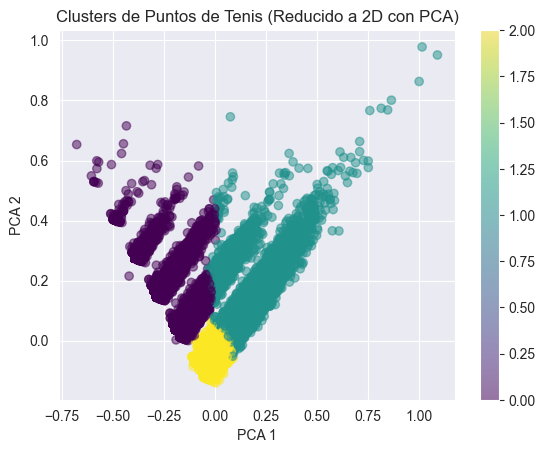

In [41]:
# Opcional: Visualizar los clusters (utilizando PCA para reducir a 2D)
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
features_pca = pca.fit_transform(features_normalized)

#add legend
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5)
plt.title('Clusters de Puntos de Tenis (Reducido a 2D con PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar()
plt.show()

In [42]:
features_df['cluster'] = kmeans.labels_

# Clasificacion

In [43]:
df_exploded['cluster'] = features_df['cluster']

In [44]:
df_exploded['cluster'].value_counts(normalize=True)

2    0.688598
1    0.182592
0    0.128810
Name: cluster, dtype: float64

In [45]:
df_exploded.to_csv('data_output/df_exploded_clustered.csv', index=False)